In [1]:
%pip install numpyro arviz causalgraphicalmodels daft jupyter ipywidgets


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os

import arviz as az
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")

In [3]:
ways = jnp.array([0, 3, 8, 9, 0])
ways / jnp.sum(ways)

Array([0.  , 0.15, 0.4 , 0.45, 0.  ], dtype=float32)

In [4]:
# In R, this is dbinom(6, size=9, prob=0.5)...
jnp.exp(dist.Binomial(9, probs=0.5).log_prob(6))

Array(0.16406256, dtype=float32)

In [10]:
import numpy as np

seq = np.arange(0, 1, 0.05)

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95]


In [8]:
jnp.ones(4)

Array([1., 1., 1., 1.], dtype=float32)

Now we explore the 

### Code 2.3

In [21]:
p_grid = jnp.linspace(start=0, stop=1, num=20)

prior = jnp.repeat(1, 20)

likelihood = jnp.exp(dist.Binomial(9, probs=p_grid).log_prob(6))

unstd_posterior = likelihood * prior

posterior = unstd_posterior / jnp.sum(unstd_posterior)

### Code 2.4

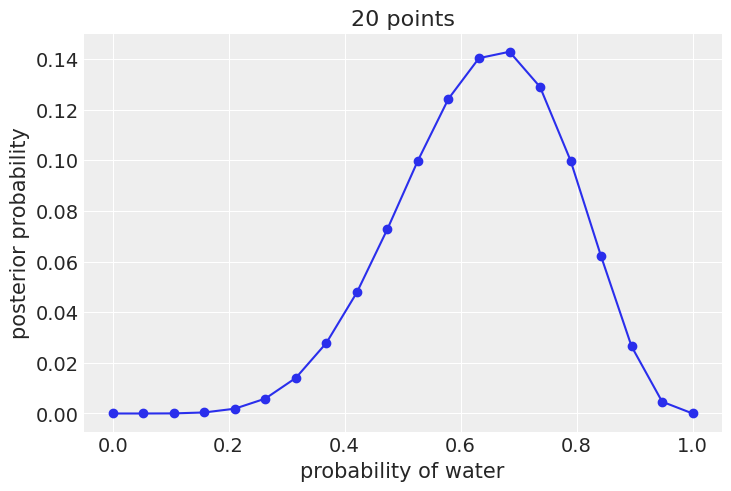

In [22]:
def plot_posterior(p_grid, posterior):
    plt.plot(p_grid, posterior, "-o")
    plt.xlabel("probability of water")
    plt.ylabel("posterior probability")
    n_points = jnp.size(p_grid)
    plt.title("{} points".format(n_points))
    plt.show()


plot_posterior(p_grid, posterior)

### Code 2.5

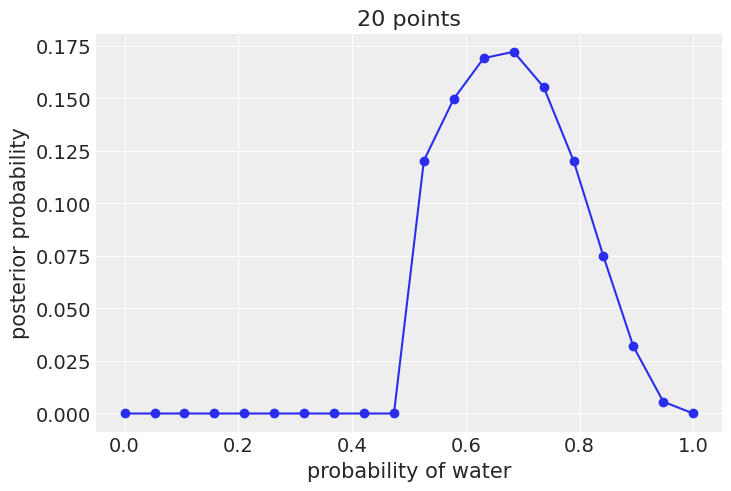

In [16]:
# Redefine the prior
prior = jnp.where(p_grid < 0.5, 0, 1)

# Then re-compute the posterior and plot it
unstd_posterior = likelihood * prior
posterior = unstd_posterior / jnp.sum(unstd_posterior)
plot_posterior(p_grid, posterior)

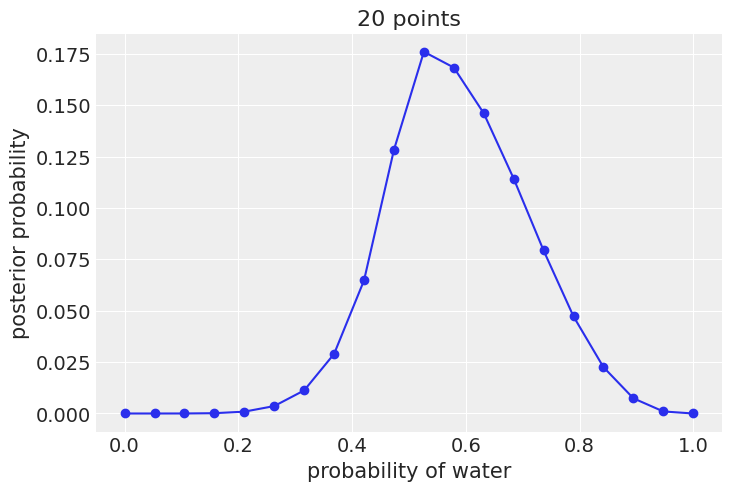

In [17]:
# Redefine the prior
prior = jnp.exp(-5 * abs(p_grid - 0.5))

# Then re-compute the posterior and plot it
unstd_posterior = likelihood * prior
posterior = unstd_posterior / jnp.sum(unstd_posterior)

plot_posterior(p_grid, posterior)

### Code 2.6

Exemplifying the use of quadratic approximation.

In [5]:
def model(W, L):
    p = numpyro.sample("p", dist.Uniform(0, 1))  # uniform prior
    numpyro.sample("W", dist.Binomial(W + L, p), obs=W)  # binomial likelihood

In [14]:
guide = AutoLaplaceApproximation(model)
svi = SVI(model, guide, optim.Adam(1), loss=Trace_ELBO(), W=6, L=3)

svi_result = svi.run(random.PRNGKey(0), 1000)
params = svi_result.params

# display summary of quadratic approximation
samples = guide.sample_posterior(random.PRNGKey(1), params, (1000,))
numpyro.diagnostics.print_summary(samples, prob=0.89, group_by_chain=False)

100%|██████████| 1000/1000 [00:00<00:00, 7054.32it/s, init loss: 2.9278, avg. loss [951-1000]: 2.7795]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         p      0.62      0.14      0.63      0.41      0.84    845.27      1.00



/var/folders/z4/p2fsmdvn5w90mgf48x40s05w0000gn/T/ipykernel_22157/388821817.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


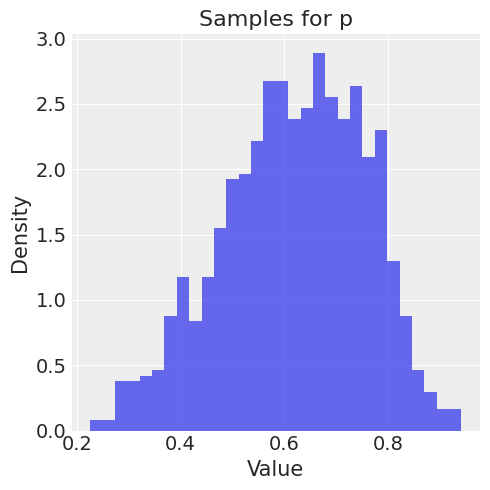

In [28]:
def plot_samples(samples):
    # Get the names of the parameters
    param_names = list(samples.keys())

    # Determine the number of subplots needed
    num_params = len(param_names)

    # Create a figure and subplots
    fig, axs = plt.subplots(1, num_params, figsize=(5 * num_params, 5))

    # Check if there is only one parameter
    if num_params == 1:
        axs = [axs]  # Convert single Axes object to a list

    # Plot the samples for each parameter
    for i, param_name in enumerate(param_names):
        param_samples = samples[param_name]

        # Plot the samples as a histogram
        axs[i].hist(param_samples, bins=30, density=True, alpha=0.7)

        # Set the title and labels for each subplot
        axs[i].set_title(f"Samples for {param_name}")
        axs[i].set_xlabel("Value")
        axs[i].set_ylabel("Density")

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Display the plot
    plt.show()


plot_samples(samples)

### Code 2.7

Since we know the posterior distribution analytically, let's compare it with the quadratic approximation.

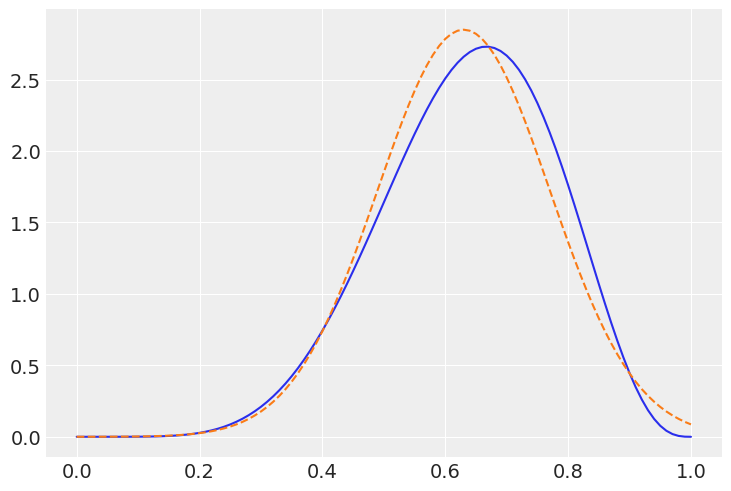

In [41]:
# analytical calculation
W = 6
L = 3
x = jnp.linspace(0, 1, 101)
plt.plot(
    x,
    jnp.exp(dist.Beta(W + 1, L + 1).log_prob(x)),
)
# quadratic approximation from above (copy mean and variance from the prior `print_summary`)
plt.plot(x, jnp.exp(dist.Normal(0.63, 0.14).log_prob(x)), "--")

# note that plt.plots are combined together into one figure because they share the same x

### Code 2.8

Implement a MCMC sampler for the model in Code 2.5.

In [43]:
n_samples = 1000
p = [jnp.nan] * n_samples
p[0] = 0.5
W = 6
L = 3

with numpyro.handlers.seed(rng_seed=0):
    for i in range(1, n_samples):
        p_new = numpyro.sample("p_new", dist.Normal(p[i - 1], 0.1))
        p_new = jnp.abs(p_new) if (p_new < 0) else p_new
        p_new = 2 - p_new if (p_new > 1) else p_new
        q0 = jnp.exp(dist.Binomial(W + L, p[i - 1]).log_prob(W))
        q1 = jnp.exp(dist.Binomial(W + L, p_new).log_prob(W))
        u = numpyro.sample("u", dist.Uniform())
        p[i] = p_new if u < q1 / q0 else p[i - 1]

### Code 2.9

Plot the prior MCMC approximation.

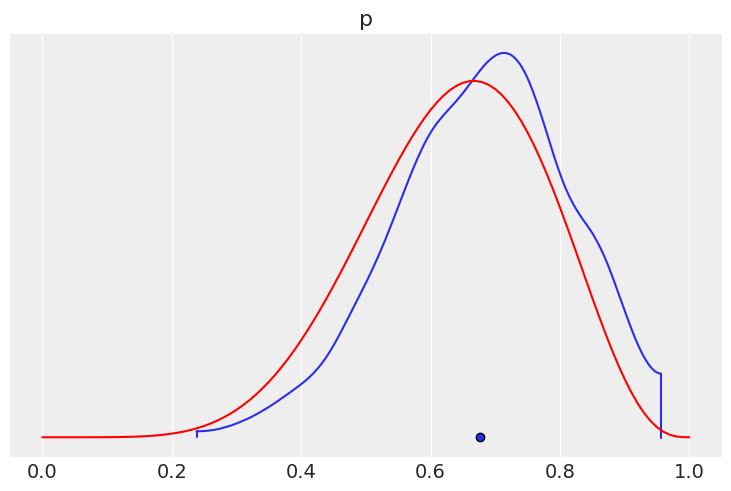

In [46]:
az.plot_density({"p": p}, hdi_prob=1)
plt.plot(x, jnp.exp(dist.Beta(W + 1, L + 1).log_prob(x)), "r-")
plt.show()